<a href="https://colab.research.google.com/github/Mariagiusi23/ID-001-AWOL-for-Audio/blob/main/notebook/01_baseline_clap_embedding_to_fm_synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**🎯 STEP 1 — Text Embedding with CLAP**

**📍 1.1 — Import required libraries**

In [ ]:
import torch
from transformers import AutoProcessor, ClapModel

# Select device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

✅ Using device: cpu


In [ ]:
# Load CLAP model and processor from Hugging Face
model_clap = ClapModel.from_pretrained("laion/clap-htsat-unfused").to(device)
processor = AutoProcessor.from_pretrained("laion/clap-htsat-unfused")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/615M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/614M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

**📍 1.2 — Prompt embedding example**

In [ ]:
prompt = "a soft metallic ringing"
inputs = processor(text=prompt, return_tensors="pt").to(device)

with torch.no_grad():
    embedding = model_clap.get_text_features(**inputs)

print("Embedding shape:", embedding.shape)
print("First 5 values:", embedding[0, :5])

# The embedding is a 512-dimensional vector that encodes the semantic meaning of the prompt.
# It will be used as input to a neural network that maps it to sound synthesis parameters.

Embedding shape: torch.Size([1, 512])
First 5 values: tensor([ 0.0216,  0.0098, -0.0779,  0.0011, -0.0370])


#**🎯 STEP 2 — From Embedding to Sound via Parametric Synthesis**

**📍 2.1 — Parametric FM Synthesizer (procedural)**

In [ ]:
import math

def synthesize(p, sr=16000, duration=1.0):
    """
    Generate sound using a simple FM synthesis algorithm.

    Args:
        p (list): [carrier_freq, modulator_freq, modulation_index, amplitude]
        sr (int): sampling rate
        duration (float): duration of the sound in seconds

    Returns:
        torch.Tensor: waveform signal
    """
    t = torch.linspace(0, duration, int(sr * duration))
    carrier, modulator, index, amplitude = p
    mod_signal = torch.sin(2 * math.pi * modulator * t)
    signal = amplitude * torch.sin(2 * math.pi * carrier * t + index * mod_signal)
    return signal


**📍 2.2 — MLP: CLAP Embedding → FM Parameters**

In [ ]:
import torch.nn as nn

class EmbedToParams(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 4),
            nn.Sigmoid()  # normalize outputs to [0,1]
        )

    def forward(self, x):
        return self.net(x)

model_mlp = EmbedToParams()

**📍 2.3 — Full Pipeline: prompt → parameters → audio**

In [ ]:
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

def generate_audio(prompt, model, processor, clap_model, sr=16000, duration=0.1):
    inputs = processor(text=prompt, return_tensors="pt").to(clap_model.device)
    with torch.no_grad():
        embedding = clap_model.get_text_features(**inputs)
        raw_p = model(embedding).squeeze()

    carrier    = 100 + 900 * raw_p[0]
    modulator  = 50 + 450 * raw_p[1]
    index      = 10 * raw_p[2]
    amplitude  = 0.9 * raw_p[3]
    p = [carrier.item(), modulator.item(), index.item(), amplitude.item()]

    signal = synthesize(p, sr=sr, duration=duration)
    signal_np = signal.numpy()

    print(f"Prompt: {prompt}")
    print(f"  Carrier freq:   {p[0]:.2f} Hz")
    print(f"  Modulator freq: {p[1]:.2f} Hz")
    print(f"  Modulation idx: {p[2]:.2f}")
    print(f"  Amplitude:      {p[3]:.2f}")

    time_axis = np.linspace(0, duration, len(signal_np))
    plt.figure(figsize=(10, 3))
    plt.plot(time_axis, signal_np, linewidth=0.3, color='black')
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    f, t_spec, Sxx = spectrogram(signal_np, fs=sr, nperseg=512)
    plt.figure(figsize=(10, 4))
    plt.imshow(10 * np.log10(Sxx + 1e-8), aspect='auto', origin='lower',
               extent=[t_spec.min(), t_spec.max(), f.min(), f.max()], cmap='viridis')
    plt.title("Spectrogram (dB)")
    plt.colorbar(label="dB")
    plt.tight_layout()
    plt.show()

    return Audio(signal_np, rate=sr)


**📍 2.4 — Usage examples**

Prompt: a deep rumbling drone
  Carrier freq:   529.82 Hz
  Modulator freq: 269.22 Hz
  Modulation idx: 4.88
  Amplitude:      0.44


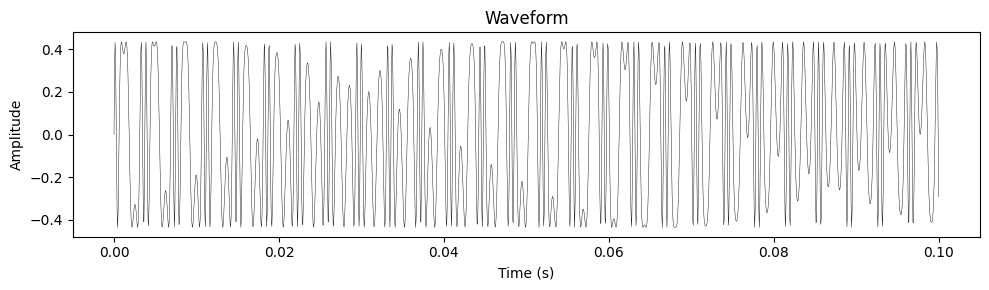

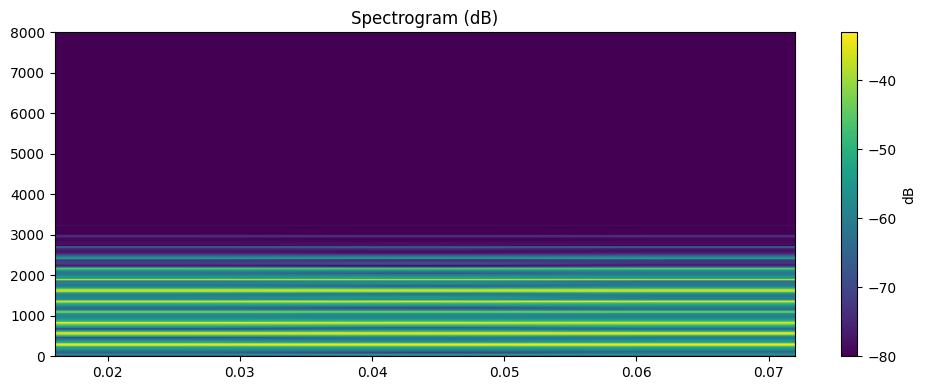

Prompt: a high-pitched whistle
  Carrier freq:   531.13 Hz
  Modulator freq: 268.26 Hz
  Modulation idx: 4.87
  Amplitude:      0.43


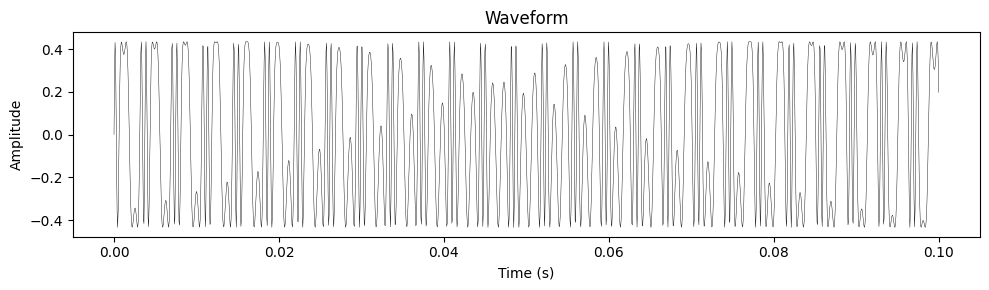

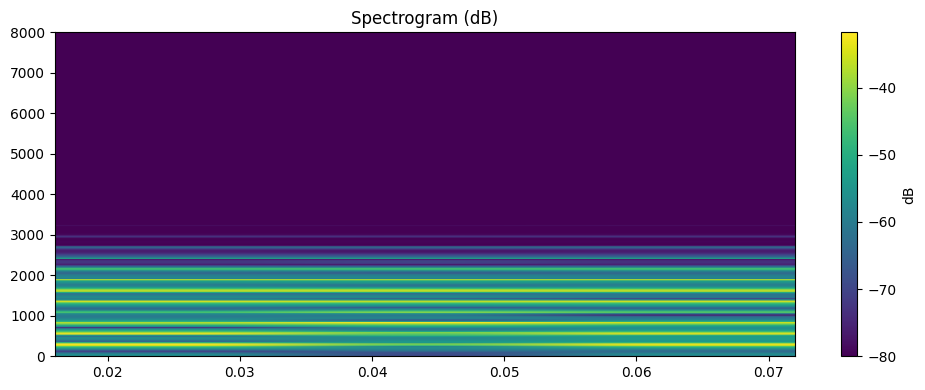

Prompt: a soft crackling fire
  Carrier freq:   530.88 Hz
  Modulator freq: 268.63 Hz
  Modulation idx: 4.88
  Amplitude:      0.44


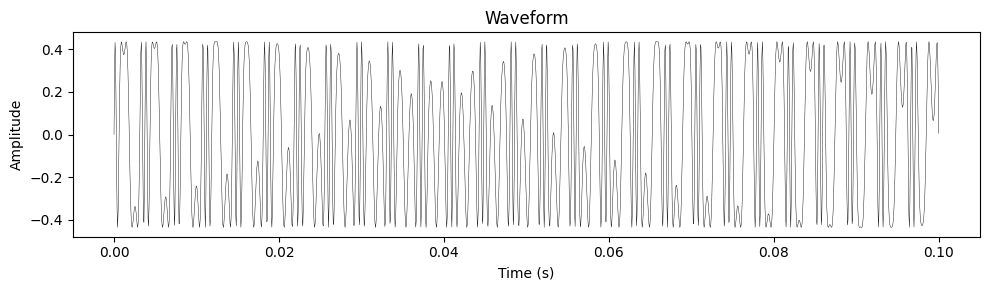

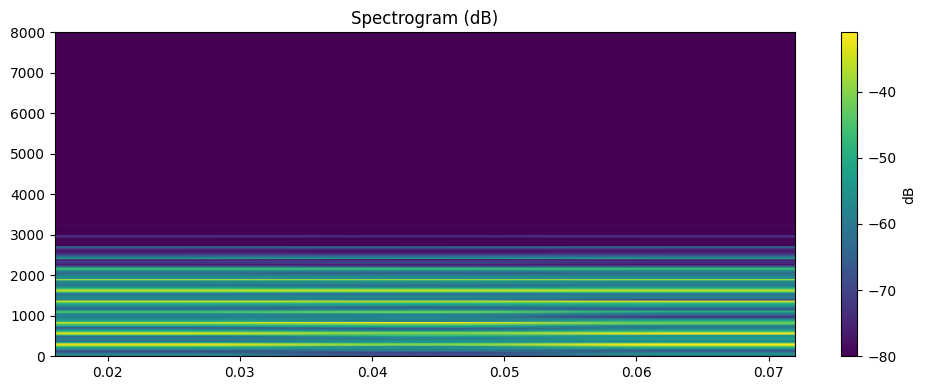

Prompt: a robotic beep sequence
  Carrier freq:   530.62 Hz
  Modulator freq: 268.25 Hz
  Modulation idx: 4.90
  Amplitude:      0.44


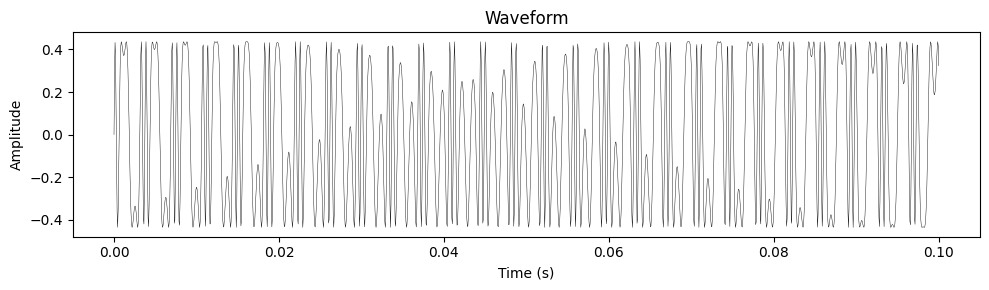

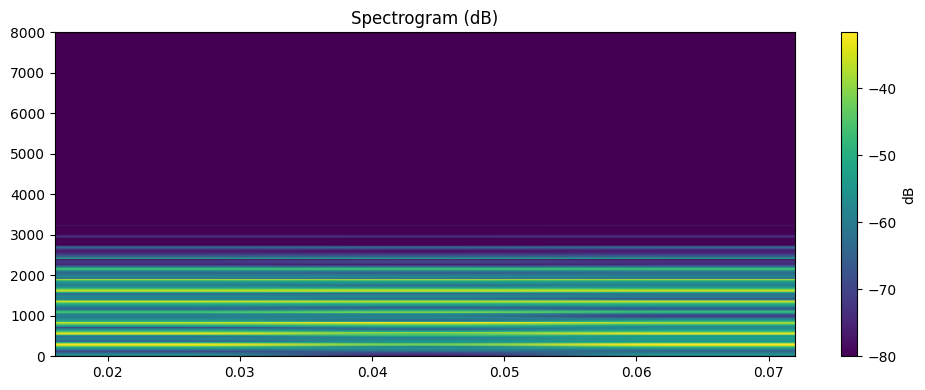

Prompt: a mellow flute tone
  Carrier freq:   530.22 Hz
  Modulator freq: 269.07 Hz
  Modulation idx: 4.88
  Amplitude:      0.43


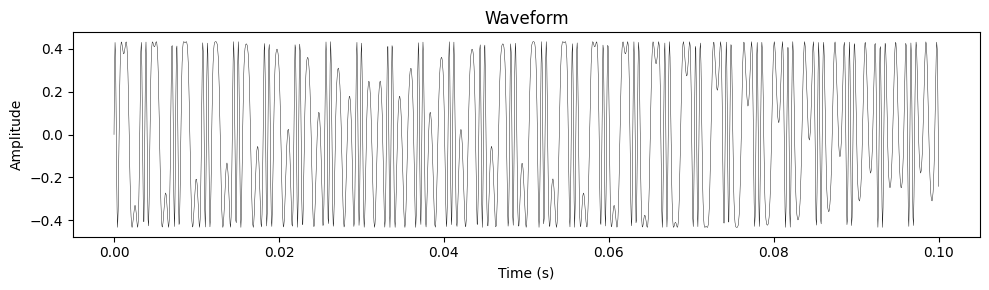

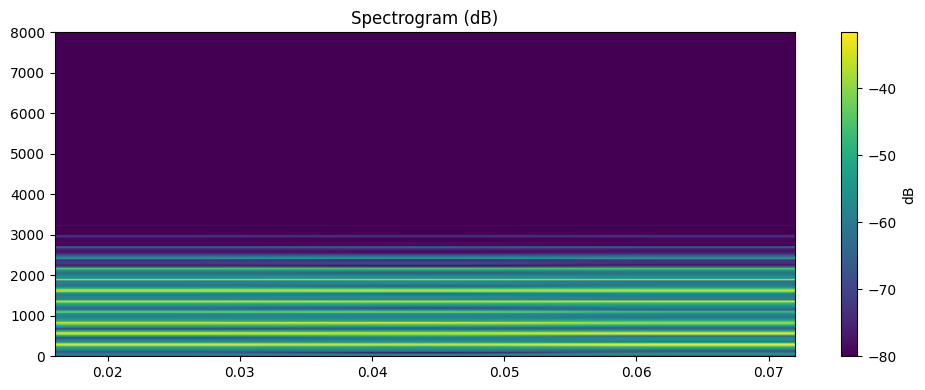

In [ ]:
example_prompts = [
    "a deep rumbling drone",
    "a high-pitched whistle",
    "a soft crackling fire",
    "a robotic beep sequence",
    "a mellow flute tone"
]

for prompt in example_prompts:
    display(generate_audio(prompt, model_mlp, processor, model_clap))

# **📌 Final comment**

This notebook demonstrates a complete baseline system for language-to-sound generation.
It shows how CLAP embeddings can be mapped to FM synthesis parameters using a simple MLP.
However, the generated sounds do not yet reflect semantic differences between prompts — this is expected, since the model has not been trained. This baseline will serve as a reference point for evaluating improvements introduced through supervised learning in the next notebook.
